In [1]:
#Import Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import glob
import datetime
import prophet #will attempt time series analysis


In [2]:
#List all csv files only
csv_files = glob.glob('data/*.{}'.format('csv'))

In [3]:
df = pd.concat([pd.read_csv(f, on_bad_lines='skip', encoding = 'unicode_escape') for f in csv_files ], ignore_index=True)  #data quality is not very good...
df

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,E0,16/08/03,Arsenal,Everton,2.0,1.0,H,1.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,E0,16/08/03,Birmingham,Tottenham,1.0,0.0,H,1.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,E0,16/08/03,Blackburn,Wolves,5.0,1.0,H,2.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,E0,16/08/03,Fulham,Middlesbrough,3.0,2.0,H,1.0,1.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,E0,16/08/03,Leicester,Southampton,2.0,2.0,D,2.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14256,NaN,05/22/2022,Crystal Palace,Man United,1.0,0.0,H,1.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14257,NaN,05/22/2022,Leicester,Southampton,4.0,1.0,H,0.0,0.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14258,NaN,05/22/2022,Liverpool,Wolves,3.0,1.0,H,1.0,1.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14259,NaN,05/22/2022,Man City,Aston Villa,3.0,2.0,H,0.0,1.0,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#check out the data
#df.to_csv('test.csv')

In [5]:
#way too many columns
df.shape

(14261, 151)

In [6]:
df['Date'].value_counts() #Also, need to Clean and Reformat Date

01/01/2020    18
02/02/2016    16
03/03/2018    14
09/09/2017    14
02/02/2019    14
              ..
12/18/2006     1
12/11/2006     1
12/10/2006     1
28/11/07       1
25/02/2022     1
Name: Date, Length: 3838, dtype: int64

In [7]:
#First focus on the ones that don't have the full year
df['Date'].str.len().value_counts()

10.0    9410
8.0     4850
Name: Date, dtype: int64

In [8]:
df.loc[(df['Date'].str.len() == 8)] #More than half the DF

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,E0,16/08/03,Arsenal,Everton,2.0,1.0,H,1.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,E0,16/08/03,Birmingham,Tottenham,1.0,0.0,H,1.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,E0,16/08/03,Blackburn,Wolves,5.0,1.0,H,2.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,E0,16/08/03,Fulham,Middlesbrough,3.0,2.0,H,1.0,1.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,E0,16/08/03,Leicester,Southampton,2.0,2.0,D,2.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5226,E0,21/05/17,Liverpool,Middlesbrough,3.0,0.0,H,1.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5227,E0,21/05/17,Man United,Crystal Palace,2.0,0.0,H,2.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5228,E0,21/05/17,Southampton,Stoke,0.0,1.0,A,0.0,0.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5229,E0,21/05/17,Swansea,West Brom,2.0,1.0,H,0.0,1.0,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Possible Solution: Split out the Date Column First

In [9]:
df[['date1', 'date2', 'date3']] = df['Date'].str.split('/', expand=True)

In [10]:
df.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,date1,date2,date3
0,E0,16/08/03,Arsenal,Everton,2.0,1.0,H,1.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,08,03
1,E0,16/08/03,Birmingham,Tottenham,1.0,0.0,H,1.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,08,03
2,E0,16/08/03,Blackburn,Wolves,5.0,1.0,H,2.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,08,03
3,E0,16/08/03,Fulham,Middlesbrough,3.0,2.0,H,1.0,1.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,08,03
4,E0,16/08/03,Leicester,Southampton,2.0,2.0,D,2.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,08,03


In [11]:
#For the dates missing the full year, add the '20' in front of it
df.loc[df.date3.str.len()==2, 'date3'] = '20' + df['date3']
#This works because we're only looking at dates from >= 2003

In [12]:
df.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,date1,date2,date3
0,E0,16/08/03,Arsenal,Everton,2.0,1.0,H,1.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,08,2003
1,E0,16/08/03,Birmingham,Tottenham,1.0,0.0,H,1.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,08,2003
2,E0,16/08/03,Blackburn,Wolves,5.0,1.0,H,2.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,08,2003
3,E0,16/08/03,Fulham,Middlesbrough,3.0,2.0,H,1.0,1.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,08,2003
4,E0,16/08/03,Leicester,Southampton,2.0,2.0,D,2.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,08,2003


#### Also need to change dd/mm/yyyy (which I think all of Europe uses) to mm/dd/yyyy

In [13]:
#df['new_col'] = 
df['Date'] = df[['date2','date1','date3']].apply(lambda row: '/'.join(row.values.astype(str)), axis=1)

In [14]:
df.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,date1,date2,date3
0,E0,08/16/2003,Arsenal,Everton,2.0,1.0,H,1.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,08,2003
1,E0,08/16/2003,Birmingham,Tottenham,1.0,0.0,H,1.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,08,2003
2,E0,08/16/2003,Blackburn,Wolves,5.0,1.0,H,2.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,08,2003
3,E0,08/16/2003,Fulham,Middlesbrough,3.0,2.0,H,1.0,1.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,08,2003
4,E0,08/16/2003,Leicester,Southampton,2.0,2.0,D,2.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,08,2003


In [15]:
df['date2'].isna().sum() #missing 

1

In [16]:
df[df['date2'].isna()] #can safely ignore this row

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,date1,date2,date3
4470,NaN,nan/nan/nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df = df[df['date2'].notna()]


In [18]:
#Still need to check if there is a month value greater than 12 that is in the date2 column, which should be month
df[df['date2'].astype(int)>12] #none, we are good to go with dates

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,date1,date2,date3
7131,NaN,16/08/2003,Arsenal,Everton,2.0,1.0,H,1.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,08,16,2003
7132,NaN,16/08/2003,Birmingham,Tottenham,1.0,0.0,H,1.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,08,16,2003
7133,NaN,16/08/2003,Blackburn,Wolves,5.0,1.0,H,2.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,08,16,2003
7134,NaN,16/08/2003,Fulham,Middlesbrough,3.0,2.0,H,1.0,1.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,08,16,2003
7135,NaN,16/08/2003,Leicester,Southampton,2.0,2.0,D,2.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,08,16,2003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14256,NaN,22/05/2022,Crystal Palace,Man United,1.0,0.0,H,1.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,05,22,2022
14257,NaN,22/05/2022,Leicester,Southampton,4.0,1.0,H,0.0,0.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,05,22,2022
14258,NaN,22/05/2022,Liverpool,Wolves,3.0,1.0,H,1.0,1.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,05,22,2022
14259,NaN,22/05/2022,Man City,Aston Villa,3.0,2.0,H,0.0,1.0,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,05,22,2022


In [19]:
#Another quality check
pd.to_datetime(df['Date']).max() #sounds about right (end of 2021/2022 season)

C:\Users\Brami\AppData\Local\Temp\ipykernel_9456\3946329100.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  pd.to_datetime(df['Date']).max() #sounds about right (end of 2021/2022 season)


Timestamp('2022-12-05 00:00:00')

In [20]:
pd.to_datetime(df['Date']).min()

C:\Users\Brami\AppData\Local\Temp\ipykernel_9456\3252792983.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  pd.to_datetime(df['Date']).min()


Timestamp('2003-01-11 00:00:00')

In [21]:
df.shape

(14260, 154)

In [22]:
#See how the null values are distributed 
df.isna().sum().sort_values(ascending=False)
#SOA: Sporting Odds Away win Odds.
#LBAHH: Ladbrokes Asian handicap home team odds.. etc
#I personally don't really care about "Winning Odds" data

SOA      13925
SOD      13925
SOH      13925
LBAHH    13619
LBAHA    13619
         ...  
HY           0
AY           0
HR           0
AR           0
date3        0
Length: 154, dtype: int64

In [23]:
#Will Drop some (a LOT of) columns/or keep a few columns
df = df[['Date','HomeTeam','AwayTeam','FTHG','FTAG','FTR','HTHG','HTAG','HTR','Referee',
         'HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR']]


In [24]:
df.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,...,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,08/16/2003,Arsenal,Everton,2.0,1.0,H,1.0,0.0,H,M Halsey,...,5.0,7.0,8.0,15.0,6.0,9.0,1.0,3.0,1.0,1.0
1,08/16/2003,Birmingham,Tottenham,1.0,0.0,H,1.0,0.0,H,R Styles,...,5.0,7.0,20.0,27.0,1.0,4.0,3.0,5.0,0.0,0.0
2,08/16/2003,Blackburn,Wolves,5.0,1.0,H,2.0,0.0,H,J Winter,...,13.0,5.0,8.0,14.0,6.0,2.0,1.0,1.0,0.0,0.0
3,08/16/2003,Fulham,Middlesbrough,3.0,2.0,H,1.0,1.0,D,G Poll,...,9.0,5.0,18.0,16.0,7.0,6.0,1.0,1.0,0.0,0.0
4,08/16/2003,Leicester,Southampton,2.0,2.0,D,2.0,0.0,H,M Riley,...,7.0,10.0,27.0,15.0,2.0,7.0,3.0,1.0,0.0,0.0


In [25]:
df.columns

Index(['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG',
       'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC',
       'HY', 'AY', 'HR', 'AR'],
      dtype='object')

In [26]:
df.dtypes

Date         object
HomeTeam     object
AwayTeam     object
FTHG        float64
FTAG        float64
FTR          object
HTHG        float64
HTAG        float64
HTR          object
Referee      object
HS          float64
AS          float64
HST         float64
AST         float64
HF          float64
AF          float64
HC          float64
AC          float64
HY          float64
AY          float64
HR          float64
AR          float64
dtype: object

In [27]:
#Change all float columns to int
for c in df.columns:
    if df[c].dtype == float:
        df[c] = df[c].astype(int)

In [28]:
df.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,...,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,08/16/2003,Arsenal,Everton,2,1,H,1,0,H,M Halsey,...,5,7,8,15,6,9,1,3,1,1
1,08/16/2003,Birmingham,Tottenham,1,0,H,1,0,H,R Styles,...,5,7,20,27,1,4,3,5,0,0
2,08/16/2003,Blackburn,Wolves,5,1,H,2,0,H,J Winter,...,13,5,8,14,6,2,1,1,0,0
3,08/16/2003,Fulham,Middlesbrough,3,2,H,1,1,D,G Poll,...,9,5,18,16,7,6,1,1,0,0
4,08/16/2003,Leicester,Southampton,2,2,D,2,0,H,M Riley,...,7,10,27,15,2,7,3,1,0,0


# Analyzing basic football stats: Most Wins, Most Goals Scored, Most Goals Conceeded since '03

* Will need to do some data manipulation

In [29]:
#1. create a "Winning Team" column
def f(row):
    if row['FTR'] == 'H': #Winning Team is the home team
        val = row['HomeTeam']
    elif row['FTR'] == 'A': #Winning Team is the away team
        val = row['AwayTeam']
    else: #Otherwise, the result is a draw
        val = 'Draw'
    return val


In [30]:
df['WinningTeam'] = df.apply(f, axis=1)

In [31]:
df.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,...,AST,HF,AF,HC,AC,HY,AY,HR,AR,WinningTeam
0,08/16/2003,Arsenal,Everton,2,1,H,1,0,H,M Halsey,...,7,8,15,6,9,1,3,1,1,Arsenal
1,08/16/2003,Birmingham,Tottenham,1,0,H,1,0,H,R Styles,...,7,20,27,1,4,3,5,0,0,Birmingham
2,08/16/2003,Blackburn,Wolves,5,1,H,2,0,H,J Winter,...,5,8,14,6,2,1,1,0,0,Blackburn
3,08/16/2003,Fulham,Middlesbrough,3,2,H,1,1,D,G Poll,...,5,18,16,7,6,1,1,0,0,Fulham
4,08/16/2003,Leicester,Southampton,2,2,D,2,0,H,M Riley,...,10,27,15,2,7,3,1,0,0,Draw


## Teams with the Most Wins from 03/04 to end of 21/22 Season

In [32]:
df['WinningTeam'].value_counts().head(10) #The Big Six Theory is validated?!

Draw          3528
Chelsea        866
Man United     856
Man City       804
Liverpool      800
Arsenal        786
Tottenham      700
Everton        560
West Ham       406
Newcastle      406
Name: WinningTeam, dtype: int64

In [33]:
df_wins_since03 = df.groupby(['WinningTeam']).size().sort_values(ascending=False).reset_index(name='Number of Wins')

Text(0, 0.5, 'Games Won')

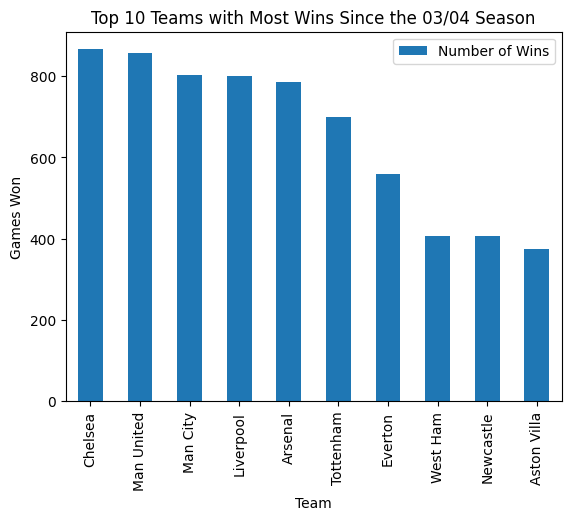

In [34]:
#Ignore the draws
ax = df_wins_since03[df_wins_since03['WinningTeam']!='Draw'][:10].plot('WinningTeam','Number of Wins', kind='bar')
ax.set_title("Top 10 Teams with Most Wins Since the 03/04 Season")
ax.set_xlabel("Team")
ax.set_ylabel("Games Won")

## Teams with the Most Goals

### Random check on Referees

In [35]:
df['Referee'].value_counts() #Mike Dean refereed the most # of games.

M Dean        1008
M Atkinson     918
A Marriner     756
M Oliver       640
A Taylor       628
              ... 
A Moss           2
D Gallaghe       2
R Martin         2
St Bennett       2
O Langford       2
Name: Referee, Length: 65, dtype: int64

Text(0, 0.5, 'Number of Games')

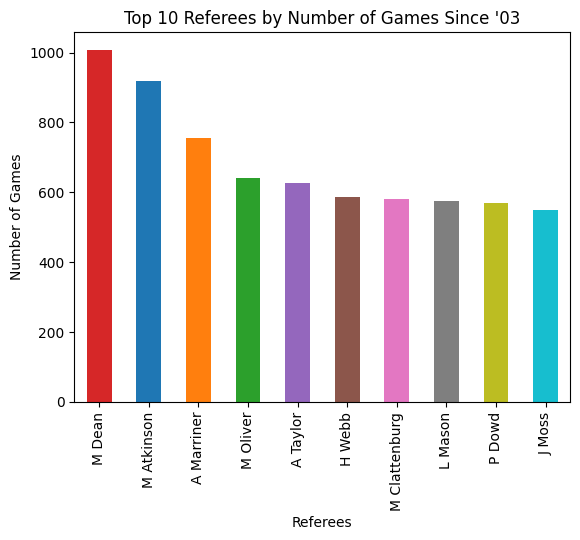

In [36]:
colors = ['#d62728', '#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
ax = df['Referee'].value_counts()[:10].plot.bar(color=colors) #Some familiar looking names...
ax.set_title("Top 10 Referees by Number of Games Since '03")
ax.set_xlabel("Referees")
ax.set_ylabel("Number of Games")

### For ease, have a combined dataset stored somewhere

In [37]:
df.to_csv('data/EPL_stats_since03.csv',index=False)